# input to GAN: 2x612x14, out put 2x612x14
--> Estimate the real and complex parts at the same time

In [1]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import skfuzzy as fuzz
from tempfile import TemporaryFile
from scipy.io import loadmat
from torch.utils.data import DataLoader, TensorDataset


In [2]:
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
print(FILE_PATH)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

/home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN/Torch_code


In [3]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Constants
file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Doppler_shift', 'freq_symb_1ant_612sub', 'new4_Gan_0_dBOutdoor1_60_1ant_612subcs.mat')

file_path = os.path.normpath(file_path)

BATCH_SIZE = 32 #64  # Batch size

NUM_EPOCHS = 10

file = h5py.File(file_path, 'r')

In [25]:
Hreal = np.array(file['H_data']) # N_samples x channel(2) x height(614) x width(14)
Hreal = torch.tensor(Hreal) 
# Y
input_data = np.array(file['H_linear_data'])
input_data = torch.tensor(input_data)             

input_data.shape

torch.Size([2353, 2, 612, 14])

In [26]:
train_size = np.floor(input_data.size(0)*0.9) //64 *64
# print(train_size)
# print(train_size/64)
# print(train_size/input_data.size(0))
train_size = int(train_size)
# [samples, 2, 612, 14]
# Split into training and validation sets
trainData   = input_data[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = Hreal[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = input_data[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = Hreal[train_size:,:,:,:].to(device, dtype=torch.float)

# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(valData.shape)
print(trainData.shape)

torch.Size([241, 2, 612, 14])
torch.Size([2112, 2, 612, 14])


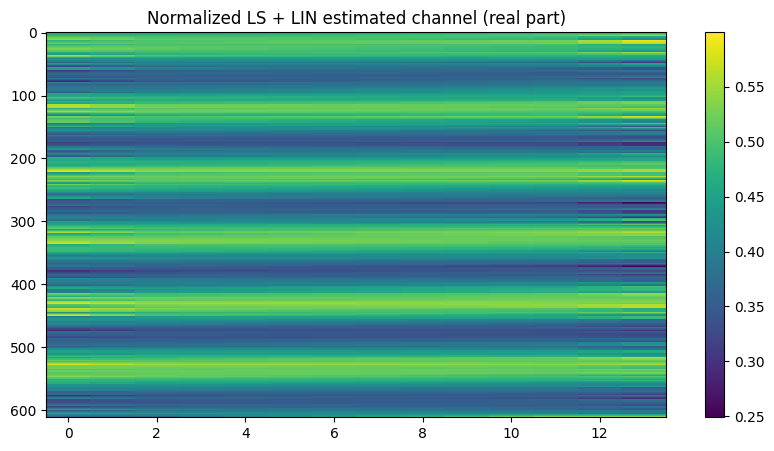

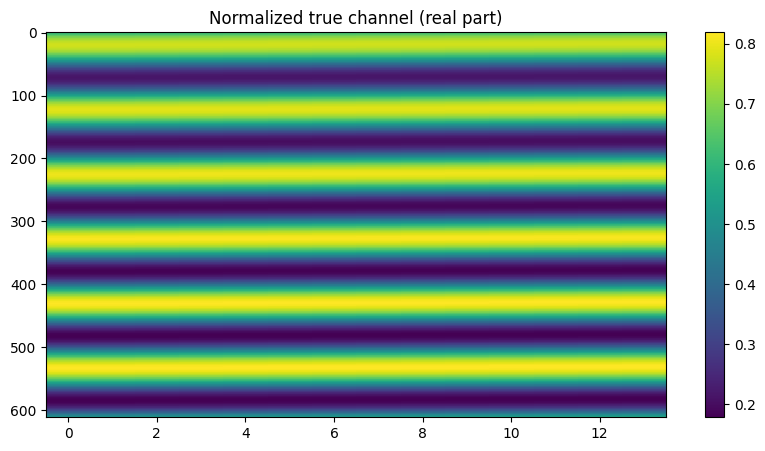

In [6]:
plot = 1
if plot:
    H_temp = valData.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Normalized LS + LIN estimated channel (real part)')
    plt.show()

    H_temp = valLabels.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('Normalized true channel (real part)')
    plt.show()

In [27]:
# # Split real and imaginary grids into 2 image sets, then concatenate
# trainData   = torch.cat((trainData[:,0,:,:], trainData[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
# trainLabels = torch.cat((trainLabels[:,0,:,:], trainLabels[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData.shape

torch.Size([2112, 2, 612, 14])

In [28]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData, trainLabels)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData, valLabels)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
input_data = np.array(file['H_linear_data'])
input_data = torch.tensor(input_data)
train_size = np.floor(input_data.size(0)*0.9) //64 *64
train_size = int(train_size)

def load_image_train(path, batch_size=BATCH_SIZE):
    """
    Load, jitter, and normalize training images.
    """
    with h5py.File(path, 'r') as file:
        Hreal = torch.tensor(np.array(file['H_data']))     # Nsamples x 2 x subcs x symb
        input_data = torch.tensor(np.array(file['H_linear_data']))
        
        train_size = np.floor(Hreal.size(0)*0.9) //64 *64
        train_size = int(train_size)
        
        trainData   = input_data[0:train_size,:,:,:].to(device, dtype=torch.float)
        trainLabels = Hreal[0:train_size,:,:,:].to(device, dtype=torch.float)
        
    batch_im = random.sample(range(trainLabels.shape[0]), trainLabels.shape[0])
    trainLabels, input_data = trainLabels[batch_im], trainData[batch_im] 
    
    n_batches = int(Hreal.shape[0] / batch_size)

    for i in range(n_batches - 1):
        yield trainLabels[i*batch_size:(i+1)*batch_size], trainData[i*batch_size:(i+1)*batch_size]


def load_image_test(path, batch_size=1):
    """
    Load and normalize test images.
    """
    with h5py.File(path, 'r') as file:
        Hreal = torch.tensor(np.array(file['H_data']))     # Nsamples x 2 x subcs x symb
        input_data = torch.tensor(np.array(file['H_linear_data']))
        
        train_size = np.floor(Hreal.size(0)*0.9) //64 *64
        train_size = int(train_size)
        
        valData   = input_data[train_size:,:,:,:].to(device, dtype=torch.float)
        valLabels = Hreal[train_size:,:,:,:].to(device, dtype=torch.float)
    n_batches = int(valLabels.shape[0] / batch_size)

    for i in range(n_batches - 1):
        yield valLabels[i*batch_size:(i+1)*batch_size], valData[i*batch_size:(i+1)*batch_size]


def load_image_test_all(path):
    """
    Load test images.
    """
    with h5py.File(path, 'r') as file:
        Hreal = torch.tensor(np.array(file['H_data'])).to(device, dtype=torch.float)   
        input_data = torch.tensor(np.array(file['H_linear_data'])).to(device, dtype=torch.float) # 
    return Hreal, input_data



In [10]:
# u1 = load_image_train(file_path, batch_size=64)
# print(type(u1))
# first_item1 = next(u1)
# # Extract target and input_image from the first item
# target1, input_image1 = first_item1
# print(target1.shape)

# u2 = load_image_test(file_path, batch_size=1)
# print(type(u2))
# first_item2 = next(u2)
# # Extract target and input_image from the first item
# target2, input_image2 = first_item2
# print(target2.shape)

# u3_1, u3_2 = load_image_test_all(file_path)
# print(type(u3_1))
# print(u3_1.shape)
# first_item3 = next(u3)
# # Extract target and input_image from the first item
# target3, input_image3 = first_item3
# print(target3.shape)


In [11]:
class ShrinkLayer(nn.Module):
    def __init__(self, filters, kernel_size, in_channels=1, stride=2, apply_batchnorm=True, add=False, padding=1):
        super(ShrinkLayer, self).__init__()
        # initializer = nn.init.normal_(mean=0., std=0.02)
        
        # conv = nn.Conv2d(filters=filters, kernel_size=kernel_size, strides=strides_s,
        #                      padding=padding_s, kernel_initializer=initializer, use_bias=False)
        conv = nn.Conv2d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, stride=stride,
                         padding=padding, bias=False)
        ac = nn.LeakyReLU(0.2)

        components = [conv]
        if apply_batchnorm:
            components.append(nn.BatchNorm2d(filters))
            components.append(ac)
        
        self.encoder_layer = nn.Sequential(*components)

    def forward(self, x):
        return self.encoder_layer(x)


class EnlargeLayer(nn.Module):
    def __init__(self, filters, kernel_size, in_channels=1, stride=2, apply_dropout=False, add=False, padding=1):
        super(EnlargeLayer, self).__init__()
        # initializer = nn.init.normal_(mean=0., std=0.02)
        # dconv = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides_s,
                                    #    padding='same', kernel_initializer=initializer, use_bias=False)
        dconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, stride=stride,
                                    padding=padding, bias=False)
        bn = nn.BatchNorm2d(filters)
        ac = nn.ReLU()

        components = [dconv, bn]
        if apply_dropout:
            components.append(nn.Dropout(p=0.5))
        components.append(ac)
        
        self.decoder_layer = nn.Sequential(*components)

    def forward(self, x):
        return self.decoder_layer(x)

class Conv1DNet(nn.Module):
    def __init__(self,in_channels=512, out_channels=512, kernel_size=5, stride=2, padding=0):
        super(Conv1DNet, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.activation = nn.ReLU()  

    def forward(self, x):
        x = self.conv1d(x)
        x = self.activation(x)
        return x

class Conv1DTransposeNet(nn.Module):
    def __init__(self,in_channels=512, out_channels=512, kernel_size=5, stride=2, padding=0):
        super(Conv1DTransposeNet, self).__init__()
        self.conv1d_transpose = nn.ConvTranspose1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.activation = nn.ReLU()  

    def forward(self, x):
        x = self.conv1d_transpose(x)
        x = self.activation(x)
        return x


In [12]:
# model = EnlargeLayer(filters=2, kernel_size=4, stride=(2,5), padding=(4,1))
# input_shape = (32, 1, 612, 14)  

# model = ShrinkLayer(filters=2, kernel_size=(4,5), stride=2, padding=0)
# input_shape = (32, 1, 1218, 67)

# # Generate a random input tensor with the specified shape
# random_input = torch.randn(input_shape)
# model.eval()
# with torch.no_grad():  # Disable gradient calculation for inference
#     output = model(random_input)
# output.shape

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Resize Input
        self.prep_layers = nn.ModuleList([
            EnlargeLayer(in_channels=2,filters=2, kernel_size=4, stride=(2,5), add=True, padding=(4,1)),
            ShrinkLayer(in_channels=2,filters=2, kernel_size=(4,5), add=True, padding=0)
        ])

        # Encoder
        self.encoder_layers = nn.ModuleList([
            ShrinkLayer(in_channels=2,filters=64*1, kernel_size=4, apply_batchnorm=False),
            ShrinkLayer(in_channels=64*1, filters=64*2, kernel_size=4),
            ShrinkLayer(in_channels=64*2, filters=64*4, kernel_size=4),
            ShrinkLayer(in_channels=64*4, filters=64*8, kernel_size=4),
            ShrinkLayer(in_channels=64*8, filters=64*8, kernel_size=4)
        ])
        
        self.transfer_layers = nn.ModuleList([
            Conv1DNet(),
            Conv1DTransposeNet()
        ])

        # Decoder
        self.decoder_layers = nn.ModuleList([
            EnlargeLayer(in_channels=64*8, filters=64*8, kernel_size=4, apply_dropout=True),
            EnlargeLayer(in_channels=64*8*2, filters=64*8, kernel_size=4, apply_dropout=True),
            EnlargeLayer(in_channels=64*8+64*4, filters=64*8, kernel_size=4, apply_dropout=True),
            EnlargeLayer(in_channels=64*8+64*2, filters=64*4, kernel_size=4)
        ])
        
        # Resize output
        self.post_layers = nn.ModuleList([
            EnlargeLayer(in_channels=2, filters=2, kernel_size=(4,5), stride=2, add=True, padding=0),
            ShrinkLayer(in_channels=2,filters=2, kernel_size=4, stride=(2,5), add=True, padding=(4,1))
        ])

        # inconv = nn.Conv2d(filters=filters, kernel_size=kernel_size, strides=strides_s,
        #                      padding=padding_s, kernel_initializer=initializer, use_bias=False)
        
        self.last = nn.ConvTranspose2d(in_channels=256+64, out_channels=2, kernel_size=4, stride=2, padding=1)
        

    def forward(self, x):
        # Pass the encoder and record xs
        for p_layer in self.prep_layers:
            x = p_layer(x)

        encoder_xs = []
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            encoder_xs.append(x)

        encoder_xs = encoder_xs[:-1][::-1]  # reverse
        
        for trans_layer in self.transfer_layers:
            x = trans_layer(x.squeeze())
            
        x= torch.unsqueeze(x, dim=-1)

        # Pass the decoder and apply skip connection
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer(x)
            x = torch.cat([x, encoder_xs[i]], dim=1)  # skip connect

        x = self.last(x)
        x = nn.Tanh()(x)
        
        for p_layer in self.post_layers:
            x = p_layer(x)

        return x


In [14]:
device

device(type='cuda', index=1)

In [15]:
# model1 = Generator()
# input_shape = (32, 2, 612, 14)

# # Generate a random input tensor with the specified shape
# random_input = torch.randn(input_shape)
# print(random_input.shape)
# with torch.no_grad():  # Disable gradient calculation for inference
#     output = model1(random_input)
# output.shape


In [16]:
# model2 = Generator()
# # random_input = torch.randn((2,612,14))
# # random_input = random_input.to(device)
# from torchsummary import summary
# # model2 = model2.to(device)
# model2 = model2.cuda()
# print(next(model2.parameters()).device)
# # summary(model2, (2,612,14), device = "cpu")

# summary(model2, [(2,612,14)], device="cuda")

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # initializer = tf.random_normal_initializer(0., 0.02)
        # Resize Input
        self.prep_layers = nn.ModuleList([
            EnlargeLayer(in_channels=2,filters=2, kernel_size=4, stride=(2,5), add=True, padding=(4,1)),
            ShrinkLayer(in_channels=2,filters=2, kernel_size=(4,5), add=True, padding=0)
        ])
        
        self.encoder_layer_1 = ShrinkLayer(in_channels= 2, filters=64, kernel_size=4, apply_batchnorm=False)
        self.encoder_layer_2 = ShrinkLayer(in_channels= 64, filters=128, kernel_size=4)
        self.encoder_layer_3 = ShrinkLayer(in_channels= 128, filters=128, kernel_size=4)

        self.zero_pad1 = nn.ZeroPad2d(padding=1)
        self.conv = nn.Conv2d(in_channels= 128, out_channels=512, kernel_size= 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        self.ac = nn.LeakyReLU()

        self.zero_pad2 = nn.ZeroPad2d(padding=1)
        self.last = nn.Conv2d(in_channels= 512, out_channels= 1, kernel_size= 4, stride=1, padding=0)
        
        # Resize output
        self.post_layer = ShrinkLayer(in_channels=1, filters=1, kernel_size=(8,1), stride=(6,1), padding=0)

    def forward(self, x):
        
        for p_layer in self.prep_layers:
            x = p_layer(x)
        
        x = self.encoder_layer_1(x)
        x = self.encoder_layer_2(x)
        x = self.encoder_layer_3(x)

        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = self.ac(x)

        x = self.zero_pad2(x)
        x = self.last(x)
        
        x = self.post_layer(x)
        
        return x


In [18]:
# model = Discriminator()

# model.to(device)
# print(next(model.parameters()).device)
# summary(model, input_size=(2,612,14))

In [19]:
# input_shape = (1, 1, 6, 2)

# # Generate a random input tensor with the specified shape
# random_input = torch.randn(input_shape)
# print(random_input.shape)
# x = torch.mean(random_input)
# x

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
    criterion = nn.BCEWithLogitsLoss()
    
    loss_disc_real = criterion(disc_real_output, torch.ones_like(disc_real_output))
    loss_disc_fake = criterion(disc_generated_output, torch.zeros_like(disc_generated_output))
    
    total_disc_loss = (torch.mean(loss_disc_real) + torch.mean(loss_disc_fake)) / 2
    
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):    
    criterion = nn.BCEWithLogitsLoss()
    loss_gen = criterion(disc_generated_output, torch.ones_like(disc_generated_output))
    
    # Calculate L2 loss
    # l2_loss = torch.mean(torch.abs(target - gen_output))
    
    # Calculate total generator loss
    total_gen_loss = torch.mean(loss_gen)  # + l2_weight * l2_loss
    
    return total_gen_loss


def generated_image(generator, test_input, target, t=0):
        # test_input == Nsamples x 2 x subcs x symb
        # target     == Nsamples x 2 x subcs x symb
    prediction = generator(test_input)  # H_fake of antenna 'ant' == Nsamples x subcs x symb x 2  
    display_list = [np.squeeze(test_input[:, :, :, 0]), np.squeeze(target[:, :, :, 0]), np.squeeze(prediction[:, :, :, 0])]
        # real part
    title = ['Input H_interpolated', 'Target H', 'Predicted H']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.savefig(os.path.join("generated_img", "img_"+str(t)+".png"))


def train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer):
        # input_image == Nsamples x 2 x subcs x symb
        # target      == Nsamples x 2 x subcs x symb
    # Ensure models are in training mode
    generator.train()
    discriminator.train()
    
    # Zero the gradients for both optimizers
    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()
    
    # Forward pass
    gen_output = generator(input_image)
    disc_real_output = discriminator(target)
    disc_generated_output = discriminator(gen_output.detach())
    
    # Calculate losses
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    # Backward pass and optimize for generator
    disc_generated_output2 = discriminator(gen_output)
    gen_loss = generator_loss(disc_generated_output2, gen_output, target)
    gen_loss.backward(retain_graph=True)  # retain_graph=True if using same computational graph for discriminator
    generator_optimizer.step()
    
    # Backward pass and optimize for discriminator
    disc_loss.backward()
    discriminator_optimizer.step()
    
    return gen_loss.item(), disc_loss.item()



In [29]:
generator = Generator()
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)

generator_optimizer = torch.optim.Adam(params= generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.RMSprop(params=discriminator.parameters(), lr=2e-5)

In [30]:
NUM_EPOCHS = 1

nm = []
gen_loss_track  = []
disc_loss_track = []
gen_val_loss_track = []
start_time = datetime.datetime.now()

for epoch in range(NUM_EPOCHS):
    generator.train()
    discriminator.train()
    running_gen_loss  = 0.0
    running_disc_loss = 0.0
    print("-----\nEPOCH:", epoch)        
    # for bi, (target, input_image) in enumerate(load_image_train(file_path)):
    for bi, (input_image, target) in enumerate(train_loader):
        # input_image == H_inter == Nsamples x 2 x subcs x symb
        # target      == H_Real  == Nsamples x 2 x subcs x symb x 2 x ant
        elapsed_time = datetime.datetime.now() - start_time
        gen_loss, disc_loss = train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer)
        running_gen_loss += gen_loss
        running_disc_loss += disc_loss
        
    avg_train_gen_loss = running_gen_loss / len(train_loader)
    avg_train_disc_loss = running_disc_loss / len(train_loader)
    gen_loss_track.append(avg_train_gen_loss)
    disc_loss_track.append(avg_train_disc_loss)
    print('Generate Loss: ', avg_train_gen_loss)
    print('Discriminate Loss: ', avg_train_disc_loss)
    
    # for bii, (target, input) in enumerate(val_loader):
    #     # input   == H_inter == Nsamples x 2 x subcs x symb
    #     # target  == H_Real  == Nsamples x 2 x subcs x symb
    #     if bii == 100:
    #         generated_image(generator, input, target, t=epoch+1)

    # real_all, input_all = load_image_test_all(file_path)
    #     # inpu_all == H_inter (test) == Nsamples x 2 x subcs x symb 
    #     # real_all == H_Real  (test) == Nsamples x 2 x subcs x symb
    
    generator.eval()
    running_gen_val_loss  = 0.0
    running_disc_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            prediction = generator(val_inputs)
            # print('shape of val_inputs', val_inputs.shape)
            # print('shape of val_targets', val_targets.shape)
            crit = nn.BCEWithLogitsLoss()
            val_gen_loss = crit(val_inputs, val_targets)
            running_gen_val_loss += val_gen_loss.item()

    avg_val_loss = running_gen_val_loss/ len(val_inputs)
    gen_val_loss_track.append(avg_val_loss)
    print('Validate Generate Loss: ', avg_val_loss)
    nm.append(fuzz.nmse(np.squeeze(val_targets), np.squeeze(prediction))/len(val_targets))
    print('NMSE of validate: ', nm)
            
    # if epoch == epochs-1:
    #     nmse_epoch = TemporaryFile()
    #     nm.cpu()
    #     np.save(nmse_epoch, nm)


-----
EPOCH: 0
Generate Loss:  0.5565669491435542
Discriminate Loss:  0.7554237851590822
Validate Generate Loss:  0.3339996408013737
NMSE of validate:  [tensor(176.2576, device='cuda:1')]


In [85]:
nmse = [tensor.cpu().numpy() for tensor in nm]

In [77]:
matrix = []

for row in range(3):
    matrix.append([])
    for col in range (5):
        matrix[row].append(col)

In [78]:
matrix

[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]

In [80]:
matrix[0][2]

2

In [ ]:
nmse

[array(79.19722, dtype=float32),
 array(79.28077, dtype=float32),
 array(79.303, dtype=float32),
 array(79.34871, dtype=float32),
 array(79.40824, dtype=float32),
 array(79.44898, dtype=float32),
 array(79.51037, dtype=float32),
 array(79.58128, dtype=float32),
 array(79.633965, dtype=float32),
 array(79.71443, dtype=float32),
 array(79.7192, dtype=float32),
 array(79.76439, dtype=float32),
 array(79.82107, dtype=float32),
 array(79.909775, dtype=float32),
 array(79.9223, dtype=float32),
 array(79.99335, dtype=float32),
 array(80.05013, dtype=float32),
 array(80.04799, dtype=float32),
 array(80.11309, dtype=float32),
 array(80.19152, dtype=float32)]

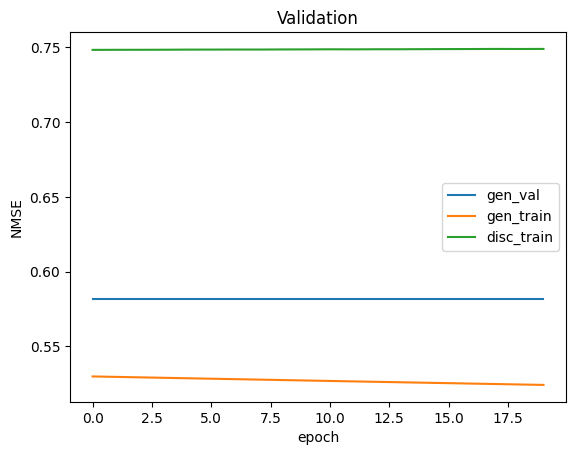

In [89]:
plt.plot(gen_val_loss_track, label='gen_val')
plt.plot(gen_loss_track, label='gen_train')
plt.plot(disc_loss_track, label='disc_train')
plt.xlabel('epoch')
plt.ylabel('NMSE')
plt.title('Validation')
plt.legend()
plt.show()

In [92]:
prediction.shape

torch.Size([15, 2, 612, 14])

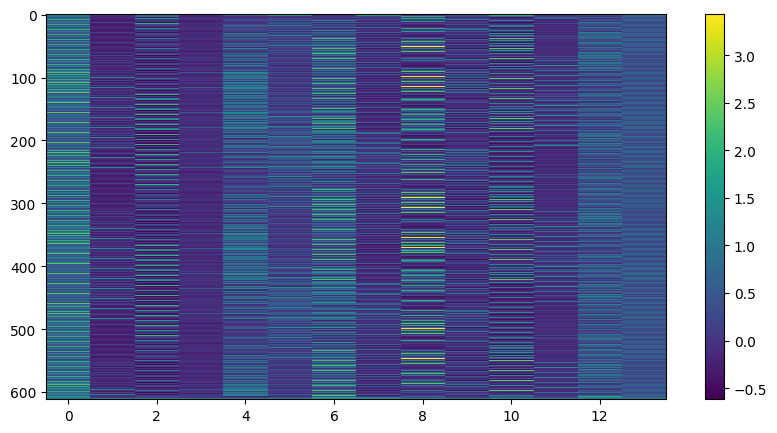

In [98]:
# Linear interpolated channel
H_test = prediction * (trainLabels_max - trainLabels_min) + trainLabels_min
H_test= H_test.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_test[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

# To do
$x+1$
- how to get the true channel
- how to get Y (received signal) <---  
- estimate: map-based channel model

In [ ]:
generator.save_weights('saved_model/test/generator_weights.h5')
generator.save('saved_model/test/generator_arch')

In [ ]:
generator.summary()

In [ ]:
discriminator.save_weights('saved_model/test/discriminator_weights.h5')
discriminator.save('saved_model/test/discriminator_arch')

In [ ]:
plt.figure()
plt.plot(np.arange(NUM_EPOCHS), nm, '^-r')
plt.xlabel('Epochs')
plt.ylabel('NMSE')
plt.show()